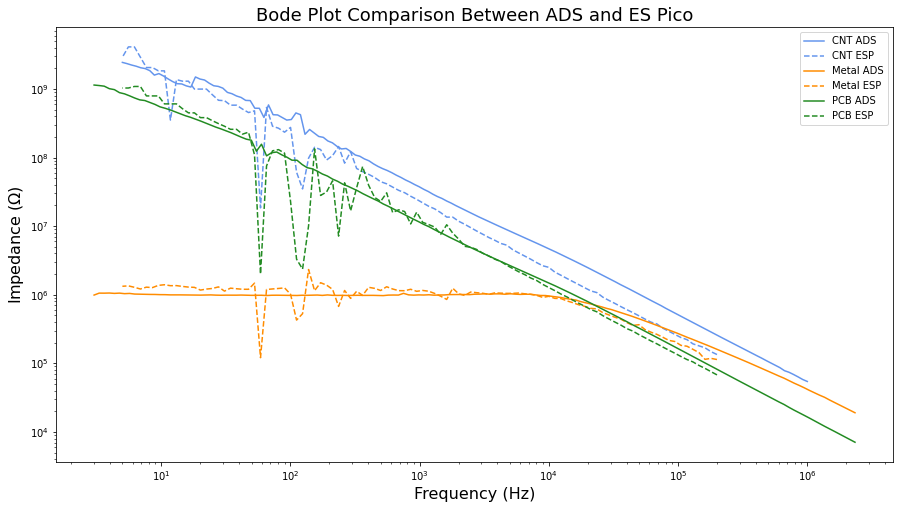

In [1]:
import csv
import numpy as np 
import matplotlib.pyplot as plt 
import codecs

def read_ads(filename, skip=31):
    frequencies = []
    impedances = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for idx in range(skip):
            next(reader)
        for row in reader:
            frequencies.append(float(row[0]))
            impedances.append(float(row[1]))
    return frequencies, impedances

def read_esp(filename):
    frequencies = []
    impedances = []
    with open(filename, 'r') as file:
        reader = csv.reader(x.replace('\0', '') for x in file)
        for idx in range(11):
            next(reader)
        for row in reader:
            if len(row) == 0:
                pass
            elif row == ['ÿþ']:
                pass
            else:
                frequencies.append(float(row[0]))
                impedances.append(float(row[3]))
    return frequencies, impedances

frequencies_CNT_ADS, impedances_CNT_ADS = read_ads(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\CNT ADS.csv')
frequencies_Metal_ADS, impedances_Metal_ADS = read_ads(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\Metal ADS.csv')
frequencies_PCB_ADS, impedances_PCB_ADS = read_ads(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\PCB ADS.csv')
frequencies_CNT_ESP, impedances_CNT_ESP = read_esp(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\CNT 2.csv')
frequencies_Metal_ESP, impedances_Metal_ESP = read_esp(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\Metal Line.csv')
frequencies_PCB_ESP, impedances_PCB_ESP = read_esp(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\PCB 4.csv')

plt.figure(figsize=(15,8))
plt.title('Bode Plot Comparison Between ADS and ES Pico', fontsize=18)
plt.ylabel('Impedance ($\Omega$)', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.plot(frequencies_CNT_ADS, impedances_CNT_ADS, color='cornflowerblue', label='CNT ADS')
plt.plot(frequencies_CNT_ESP, impedances_CNT_ESP, '--', color='cornflowerblue', label='CNT ESP')
plt.plot(frequencies_Metal_ADS, impedances_Metal_ADS, color='darkorange', label='Metal ADS')
plt.plot(frequencies_Metal_ESP, impedances_Metal_ESP, '--', color='darkorange', label='Metal ESP')
plt.plot(frequencies_PCB_ADS, impedances_PCB_ADS, color='forestgreen', label='PCB ADS')
plt.plot(frequencies_PCB_ESP, impedances_PCB_ESP, '--', color='forestgreen', label='PCB ESP')
plt.legend()
plt.savefig(R'D:\Local Documents\Research\Khalid\ES Pico Initial Tests\AggregationPlot.png',bbox_inches='tight')
plt.show()

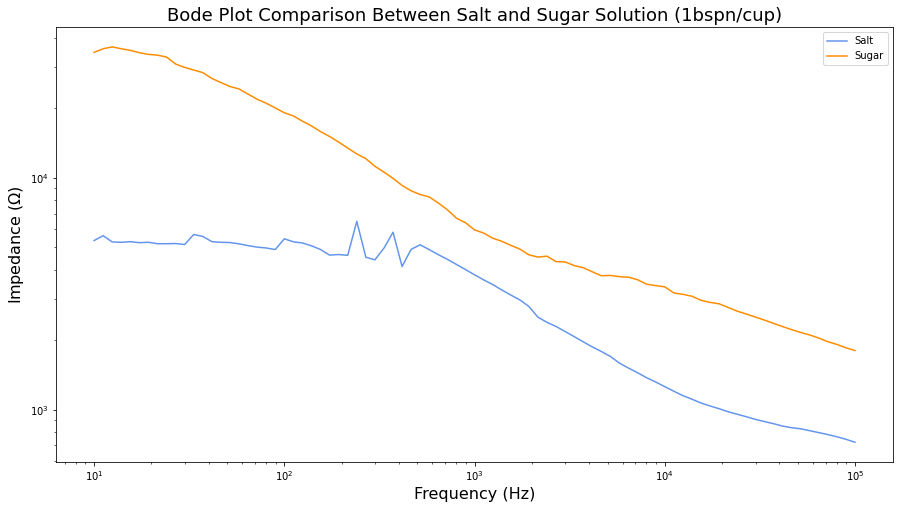

In [7]:
frequencies_Salt, impedances_Salt = read_esp(R'D:\Local Documents\Research\Khalid\Solution Measurements\CNT\Sugar v Salt\Salt2.csv')
frequencies_Sugar, impedances_Sugar = read_esp(R'D:\Local Documents\Research\Khalid\Solution Measurements\CNT\Sugar v Salt\Sugar2.csv')

plt.figure(figsize=(15,8))
plt.title('Bode Plot Comparison Between Salt and Sugar Solution (1Tbspn/cup)', fontsize=18)
plt.ylabel('Impedance ($\Omega$)', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.plot(frequencies_Salt, impedances_Salt, color='cornflowerblue', label='Salt')
plt.plot(frequencies_Sugar, impedances_Sugar, color='darkorange', label='Sugar')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

In [20]:
import scipy.optimize as opt
import numpy as np

def read_ads_2(filename):
    frequencies = []
    impedances = []
    with open(filename, 'r') as file:
        reader = csv.reader(file)
        for idx in range(31):
            next(reader)
        for row in reader:
            frequencies.append(float(row[0]))
            impedances.append(float(row[2]))
    return np.array(frequencies), np.array(impedances)

def calc_cap(frequencies, impedances, resistance=20*10**3, idx=-1):

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx], idx

    # frequency = frequencies[idx]
    # impedance = impedances[idx]
    # omega = 2 * np.pi * frequency
    # capacitance = omega / np.sqrt(impedance**2 - resistance**2)

    zerodB = np.mean(impedances[0:30])
    minus3dB, minus3dBIdx = find_nearest(impedances, zerodB)
    omega = 2 * np.pi * frequencies[minus3dBIdx]
    capacitance = 1 / (omega * minus3dB * resistance)

    return capacitance

def net_impedance(f, Cc, Cdl, Rct, Rpo, Rs):
    pi = np.pi
    nterm1 = 16 * pi**4 * Cc**2 * Cdl**2 * Rct**2 * Rpo**2 * Rs**2
    nterm2 = 4 * pi**2 * f**2 * (2*Cc*Cdl*Rct**2*Rs**2 + Cc**2*Rs**2 * (Rct+Rpo)**2 + Cdl**2 * Rct**2 * (Rpo + Rs)**2)
    nterm3 = (Rct + Rpo + Rs)**2
    dterm1 = 4 * pi**2 * f**2 * (Cc**2 * Rpo**2 * (4 * pi**2 * f**2 * Cdl**2 * Rct**2 + 1) + Rct**2 * (Cc+Cdl)**2 + 2 * Cc**2 * Rct * Rpo) + 1
    return np.sqrt((nterm1 + nterm2 + nterm3) / dterm1)

def series_RLC(f, R, L, C):
    omega = 2* np.pi * f
    # term1 = R
    # term2 = omega * L
    # term3 = 1 / (omega * C)
    # return np.sqrt(term1**2 + (term2 - term3)**2)
    # nterm = C*R*omega
    # dterm = 1-2*C*L*omega**2 + C**2 * R**2 * omega**2 + C**2 * L**2 * omega**4
    # return nterm / np.sqrt(dterm)
    return np.sqrt(R**2 + (C * L*omega**2 - 1)**2 / (C**2 * omega**2))

def fit_cap(frequencies, impedances, function='RC'):
    bounds = ([1*10**3,0,0],[1.5*10**3,10**(-5),10])
    # bounds = (0, np.inf)
    if function == 'RC':
        guess = [1.2*10**-9, 4*10**-6, 2500, 3400, 20]
        params, cov = opt.curve_fit(net_impedance, frequencies, impedances, guess, bounds=bounds)
    elif function == 'RLC':
        guess = [1.2*10**3, 10**(-6), 1*10**-2]
        params, cov = opt.curve_fit(series_RLC, frequencies, impedances, guess, bounds=bounds)
    return params, cov

def plot_impedance(filename, title, savefile, listCap=True):
    frequencies, impedances = read_ads_2(filename)
    plt.figure(figsize=(8,6))
    plt.plot(frequencies, impedances, color='cornflowerblue', label='Data')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title, fontsize=18)
    plt.ylabel('Impedance ($\Omega$)', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=16)
    # plt.axvline(x=frequencies[30], color='red')
    xmin, xmax, ymin, ymax = plt.axis()
    # plt.annotate('Capacitance:' + str(round(cap,2)), (xmin+10,ymin+1000))

    params, cov = fit_cap(frequencies, impedances)
    y_fit = net_impedance(frequencies, *params)
    if listCap == True:
        plt.text(xmin+0.3*xmin, ymin+0.3*ymin, 
                 '$C_c$: {:.2E} farads \
                 \n$C_{{dl}}$: {:.2E} farads \
                 \n$R_{{ct}}$: {:.2E} ohms \
                 \n$R_{{po}}$: {:.2E} ohms \
                 \n$R_s$: {:.2E} ohms'.format(params[0], params[1], params[2], params[3], params[4]), 
                 bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), fontsize=14, wrap=True)
        plt.plot(frequencies, y_fit, '--', color='darkorange', label='Fit')

    plt.legend()
    plt.savefig(savefile,bbox_inches='tight')
    plt.show()

def plot_impedance_2(filename, title, savefile, listCap=True):
    frequencies, impedances = read_ads_2(filename)
    # print(frequencies[:80])
    # print(impedances[:80])
    plt.figure(figsize=(8,6))
    plt.plot(frequencies, impedances, color='cornflowerblue', label='Data')
    plt.xscale('log')
    plt.yscale('log')
    plt.title(title, fontsize=18)
    plt.ylabel('Impedance ($\Omega$)', fontsize=16)
    plt.xlabel('Frequency (Hz)', fontsize=16)
    # plt.axvline(x=frequencies[30], color='red')
    # xmin, xmax, ymin, ymax = plt.axis()
    # plt.annotate('Capacitance:' + str(round(cap,2)), (xmin+10,ymin+1000))

    params, cov = fit_cap(frequencies[0:70], impedances[0:70], 'RLC')
    print(params)
    y_fit = series_RLC(frequencies[0:70], *params)
    # if listCap == True:
    #     plt.text(xmin+0.3*xmin, ymin+0.3*ymin, 
    #              '$R$: {:.2E} ohms \
    #              \n$L$: {:.2E} henries \
    #              \n$C$: {:.2E} ohms'.format(params[0], params[1], params[2]), 
    #              bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), fontsize=14, wrap=True)
    # plt.plot(frequencies[0:70], y_fit, '--', color='darkorange', label='Fit')

    plt.legend()
    plt.savefig(savefile,bbox_inches='tight')
    plt.show()

    return frequencies, impedances



[1.49963916e+03 6.15148494e-06 1.12813714e-08]


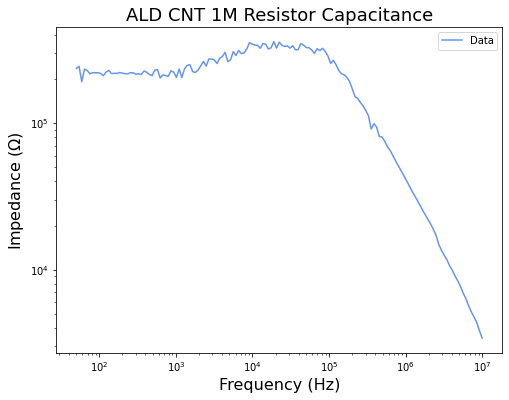

(array([5.00000000e+01, 5.42388165e+01, 5.88369842e+01, 6.38249678e+01,
        6.92358143e+01, 7.51053725e+01, 8.14725302e+01, 8.83794723e+01,
        9.58719595e+01, 1.03999632e+02, 1.12816339e+02, 1.22380495e+02,
        1.32755464e+02, 1.44009985e+02, 1.56218622e+02, 1.69462264e+02,
        1.83828653e+02, 1.99412971e+02, 2.16318471e+02, 2.34657157e+02,
        2.54550529e+02, 2.76130388e+02, 2.99539709e+02, 3.24933586e+02,
        3.52480263e+02, 3.82362246e+02, 4.14777513e+02, 4.49940828e+02,
        4.88085160e+02, 5.29463228e+02, 5.74349177e+02, 6.23040393e+02,
        6.75859470e+02, 7.33156355e+02, 7.95310660e+02, 8.62734178e+02,
        9.35873615e+02, 1.01521354e+03, 1.10127962e+03, 1.19464207e+03,
        1.29591944e+03, 1.40578273e+03, 1.52495983e+03, 1.65424032e+03,
        1.79448075e+03, 1.94661024e+03, 2.11163671e+03, 2.29065352e+03,
        2.48484671e+03, 2.69550290e+03, 2.92401774e+03, 3.17190523e+03,
        3.44080771e+03, 3.73250676e+03, 4.04893498e+03, 4.392188

In [21]:
# plot_impedance_2(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 1M dark.csv', 
#                'ALD CNT 1M Resistor Dark Capacitance',
#                R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 1M dark plot.png',
#                listCap=True)

plot_impedance_2(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 1M.csv', 
               'ALD CNT 1M Resistor Capacitance',
               R'D:\Local Documents\Research\Khalid\CNT Capacitance Measurements\Cap Characterization\ALD CNT Cap 1M plot.png',
               listCap=False)

# plot_impedance_2(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 100k ohm 100-1m.csv', 
#                'ALD CNT 100k Resistor Capacitance',
#                R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 100k ohm 100-1m plot.png',
#                listCap=True)

# plot_impedance_2(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 100k ohm.csv', 
#                'ALD CNT 100k Resistor Capacitance',
#                R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap 100k ohm.csv plot.png', listCap=True)

# f, i = plot_impedance_2(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap.csv', 
#                'ALD CNT Capacitance',
#                R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap.csv plot.png',
#                listCap=True)

# plt.figure(figsize=(8,6))
# plt.plot(f, i, color='cornflowerblue', label='data')
# plt.xscale('log')
# plt.yscale('log')
# plt.title('ALD CNT Capacitance', fontsize=18)
# plt.ylabel('Impedance ($\Omega$)', fontsize=16)
# plt.xlabel('Frequency (Hz)', fontsize=16)
# f_list = np.linspace(3000,20000,100)
# R = 1.7*10**3
# L = 4.3*10**-2
# C = 1.7*10**-8
# i_list = series_RLC(f_list, R, L, C)
# plt.plot(f_list, i_list, '--', color='darkorange', label='fit')
# xmin, xmax, ymin, ymax = plt.axis()
# plt.text(xmin+50000, ymin+0.3*ymin, 
#             '$R$: {:.2E} ohms \
#             \n$L$: {:.2E} henries \
#             \n$C$: {:.2E} farads'.format(R, L, C), 
#             bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'), fontsize=14, wrap=True)
# plt.legend()
# plt.savefig(R'D:\Local Documents\Research\Khalid\LBL ALD CNT Cap Measurements\ALD CNT Cap.csv plot manual.png',bbox_inches='tight')
# plt.show()

# plot_impedance_2(R'D:\Local Documents\Research\Khalid\CNT Capacitance Measurements\Cap Characterization\Impedance Analyzer.csv', 
#                'No ALD Coating',
#                R'D:\Local Documents\Research\Khalid\CNT Capacitance Measurements\Cap Characterization\No Coating Impedance.png',
#                listCap=False)

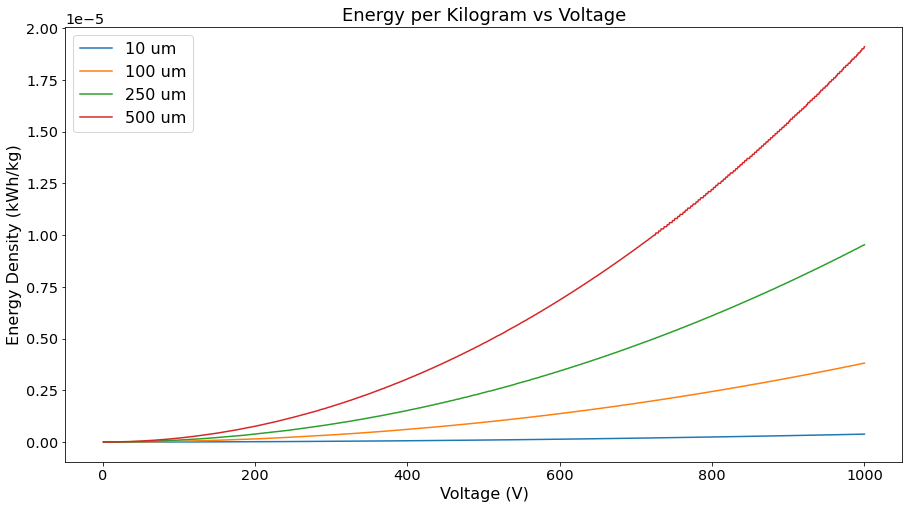

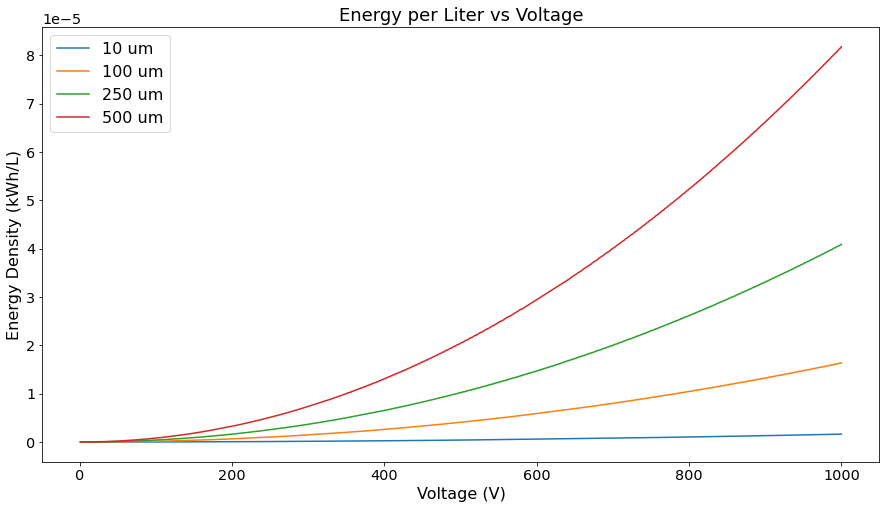

In [3]:
import ast
# def read_labview(filename):
#     frequencies = []
#     impedances = []
#     with open(filename, 'r') as file:
#         reader = csv.reader(file)
#         for idx in range(1):
#             next(reader)
#         for row in reader:
#             frequencies.append(float(row[0]))
#             impedances.append(float(row[2]))
#     return np.array(frequencies), np.array(impedances)

def read_labview(filename):
    x = []
    y = []
    openedFile = open(filename, 'r')
    lines = openedFile.readlines()
    lines = lines[1:]
    for line in lines:
        newLine = line[:-1]
        newLineSplit = newLine.split('\t')
        x.append(float(newLineSplit[0]))
        y.append(float(newLineSplit[1]))
    return np.array(x), np.array(y)


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

tenxkg, tenykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\10um WhPerKg vs Voltage.txt')
hundredxkg, hundredykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um WhPerKg vs Voltage.txt')
twofiftyxkg, twofiftyykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\250um WhPerKg vs Voltage.txt')
fivexkg, fiveykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\500um WhPerKg vs Voltage.txt')
plt.figure(figsize=(15,8))
plt.title('Energy per Kilogram vs Voltage', fontsize=18)
plt.ylabel('Energy Density (kWh/kg)', fontsize=16)
plt.xlabel('Voltage (V)', fontsize=16)
plt.plot(tenxkg, tenykg, label='10 um')
plt.plot(hundredxkg, hundredykg, label='100 um')
plt.plot(twofiftyxkg, twofiftyykg, label='250 um')
plt.plot(fivexkg, fiveykg, label='500 um')
plt.legend(prop={'size': 16})
plt.savefig(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\PerKilogram Plot.png',bbox_inches='tight')
plt.show()

tenxL, tenyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\10um WhPerLiter vs Voltage.txt')
hundredxL, hundredyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um WhPerLiter vs Voltage.txt')
twofiftyxL, twofiftyyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\250um WhPerLiter vs Voltage.txt')
fivexL, fiveyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\500um WhPerLiter vs Voltage.txt')
plt.figure(figsize=(15,8))
plt.title('Energy per Liter vs Voltage', fontsize=18)
plt.ylabel('Energy Density (kWh/L)', fontsize=16)
plt.xlabel('Voltage (V)', fontsize=16)
plt.plot(tenxL, tenyL, label='10 um')
plt.plot(hundredxL, hundredyL, label='100 um')
plt.plot(twofiftyxL, twofiftyyL, label='250 um')
plt.plot(fivexL, fiveyL, label='500 um')
plt.legend(prop={'size': 16})
plt.savefig(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\PerLiter Plot.png',bbox_inches='tight')
plt.show()

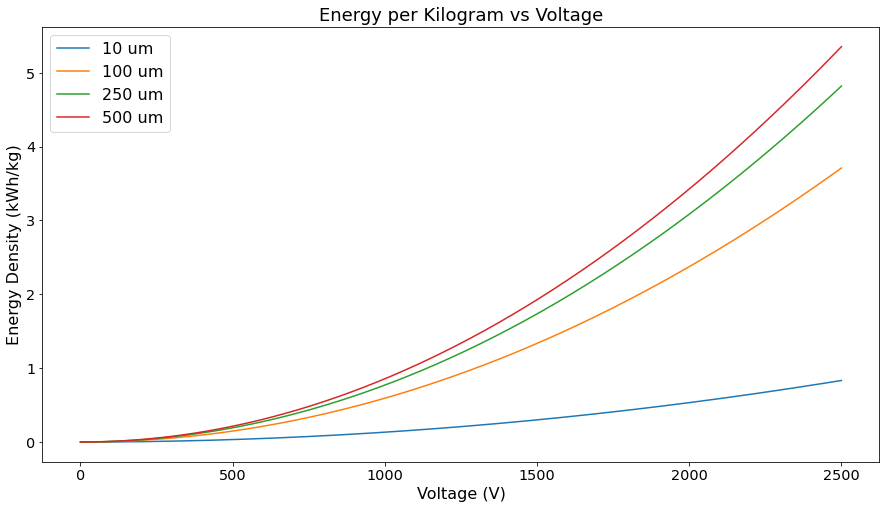

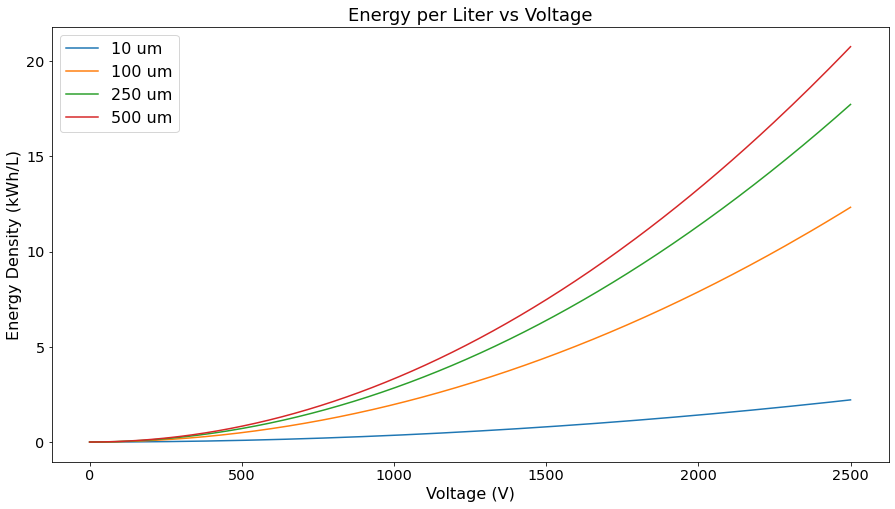

In [4]:
def read_labview(filename):
    x = []
    y = []
    openedFile = open(filename, 'r')
    lines = openedFile.readlines()
    lines = lines[1:]
    for line in lines:
        newLine = line[:-1]
        newLineSplit = newLine.split('\t')
        x.append(float(newLineSplit[0]))
        y.append(float(newLineSplit[1]))
    return np.array(x), np.array(y)


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

tenxkg, tenykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 10um CNT Wh per kg.txt')
hundredxkg, hundredykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 100um CNT Wh per kg.txt')
twofiftyxkg, twofiftyykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 250um CNT Wh per kg.txt')
fivexkg, fiveykg = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 500um CNT Wh per kg.txt')
plt.figure(figsize=(15,8))
plt.title('Energy per Kilogram vs Voltage', fontsize=18)
plt.ylabel('Energy Density (kWh/kg)', fontsize=16)
plt.xlabel('Voltage (V)', fontsize=16)
plt.plot(tenxkg, tenykg/1000, label='10 um')
plt.plot(hundredxkg, hundredykg/1000, label='100 um')
plt.plot(twofiftyxkg, twofiftyykg/1000, label='250 um')
plt.plot(fivexkg, fiveykg/1000, label='500 um')
plt.legend(prop={'size': 16})
plt.savefig(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si per kg plot.png',bbox_inches='tight')
plt.show()

tenxL, tenyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 10um CNT Wh per L.txt')
hundredxL, hundredyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 100um CNT Wh per L.txt')
twofiftyxL, twofiftyyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 250um CNT Wh per L.txt')
fivexL, fiveyL = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si 500um CNT Wh per L.txt')
plt.figure(figsize=(15,8))
plt.title('Energy per Liter vs Voltage', fontsize=18)
plt.ylabel('Energy Density (kWh/L)', fontsize=16)
plt.xlabel('Voltage (V)', fontsize=16)
plt.plot(tenxL, tenyL/1000, label='10 um')
plt.plot(hundredxL, hundredyL/1000, label='100 um')
plt.plot(twofiftyxL, twofiftyyL/1000, label='250 um')
plt.plot(fivexL, fiveyL/1000, label='500 um')
plt.legend(prop={'size': 16})
plt.savefig(R'D:\Local Documents\Research\Khalid\CNT Simulation\Energy Density vs Voltage\100um Si per L plot.png',bbox_inches='tight')
plt.show()

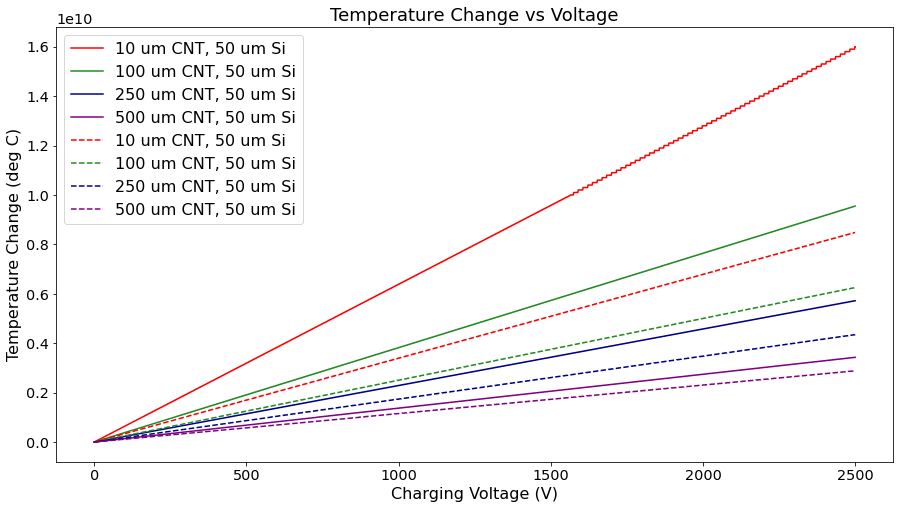

In [6]:
lowSi10x, lowSi10y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\50um Si 10um CNTs.txt')
lowSi100x, lowSi100y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\50um Si 100um CNTs.txt')
lowSi250x, lowSi250y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\50um Si 250um CNTs.txt')
lowSi500x, lowSi500y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\50um Si 500um CNTs.txt')
hiSi10x, hiSi10y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\100um Si 10um CNTs.txt')
hiSi100x, hiSi100y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\100um Si 100um CNTs.txt')
hiSi250x, hiSi250y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\100um Si 250um CNTs.txt')
hiSi500x, hiSi500y = read_labview(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\100um Si 500um CNTs.txt')

plt.figure(figsize=(15,8))
plt.title('Temperature Change vs Voltage', fontsize=18)
plt.ylabel('Temperature Change (deg C)', fontsize=16)
plt.xlabel('Charging Voltage (V)', fontsize=16)

plt.plot(lowSi10x, lowSi10y, color='red', label='10 um CNT, 50 um Si')
plt.plot(lowSi100x, lowSi100y, color='forestgreen', label='100 um CNT, 50 um Si')
plt.plot(lowSi250x, lowSi250y, color='darkblue', label='250 um CNT, 50 um Si')
plt.plot(lowSi500x, lowSi500y, color='purple', label='500 um CNT, 50 um Si')

plt.plot(hiSi10x, hiSi10y, '--', color='red', label='10 um CNT, 50 um Si')
plt.plot(hiSi100x, hiSi100y, '--', color='forestgreen', label='100 um CNT, 50 um Si')
plt.plot(hiSi250x, hiSi250y, '--', color='darkblue', label='250 um CNT, 50 um Si')
plt.plot(hiSi500x, hiSi500y, '--', color='purple', label='500 um CNT, 50 um Si')

plt.legend(prop={'size': 16})
plt.savefig(R'D:\Local Documents\Research\Khalid\CNT Simulation\Temperature Change\Temp Plot.png',bbox_inches='tight')
plt.show()

Cap in F: 1.6305896253834915e-12
Unc in cap in F: 8.140594806755818e-15


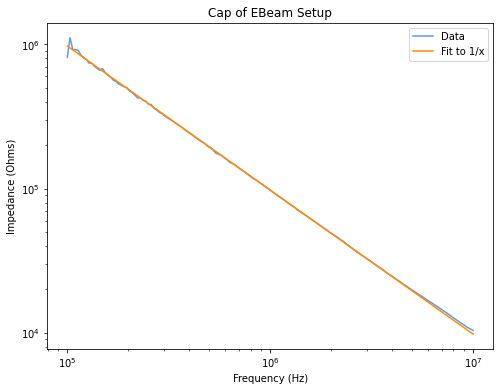

In [19]:
import scipy.optimize as opt
f, Z = read_ads(filename=r'D:\Local Documents\Research\Khalid\EBeam\EBeam Cap.csv')

def linear(x, a):
    return a / x 

popt, pcov = opt.curve_fit(linear, f, Z, p0=[1e8])
c = 1 / popt[0] / 2 / np.pi
delta_c = np.sqrt(pcov[0,0]) / popt[0]**2 / 2 / np.pi

print('Cap in F:', c)
print('Unc in cap in F:', delta_c)

plt.figure(figsize=(8,6))
plt.title('Cap of EBeam Setup')
plt.plot(f,Z,color='cornflowerblue', label='Data')
plt.plot(f, linear(f, *popt), color='darkorange', label='Fit to 1/x')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Impedance (Ohms)')
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()